### Sensitivity of hydraulic head at a point to source/sink term flux under steady state flow conditions

The sensitivity of hydraulic head ($h$) at a given point ($x'$) to the flux to/from a source/sink term located at $x_w$ under steady state flow conditions in a one-dimensional plane can be calculated using an adjoint state-based approach as:
$$\begin{align}\cr
\frac{\partial h(x')}{\partial Q_w(x_w)}=\int\limits_X\psi^*(x)\;\delta(x-x_w)\; dx
\cr\cr\end{align}$$
This expression states that this sensitivity is equal to the spatial integral of the adjoint state variable at the source/sink term location only, as calculated by the adjoint state model.

### 1. Model setup

The forward model is defined using the following five parameters:
1. Location of Dirichlet boundary ($x_{\Gamma_1}$)
2. Hydraulic head specified on Dirichlet boundary ($h_{\Gamma_1}$) 
3. Location of source/sink term ($x_w$)
4. Flux specified at source/sink term ($Q_w$) 
5. Hydraulic conductivity ($K$)

Top and bottom of aquifer elevations are set to -100.0 and -101.0 metres respectively (resulting in an aquifer that is one metre thick) to ensure confined conditions.

Zero-valued Neumann boundary conditions are specified on the left-hand side of the model to represent an impermeable boundary.

Dirichlet boundary conditions are specified on the right-hand side of the model to represent outflows.

The hydraulic head observation of interest is located at the midpoint of the model domain (i.e. at $x_{obs}$).

Values for the 'base' parameter set are defined as follows. These can be modified to demonstrate the method for other model configurations.

In [1]:
import numpy as np

BC1x  = 7.0
BC1h  = 1.0
BC2x  = 0.0
xw    = 1.5
Qw    = 1.0
obsx  = (BC1x-BC2x)/2.
K     = 0.2
dpar  = 1e-4
dx    = 1.0
X     = np.arange(BC2x+0.5, BC1x-0.5+dx, dx)

The forward model and boundary conditions can be presented visually as follows.

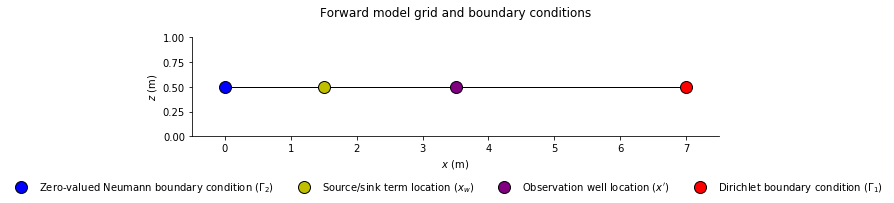

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_aspect(1.5)
s.set_title('Forward model grid and boundary conditions\n')
s.set_xlim(BC2x-0.5, BC1x+0.5)
s.set_ylim(0., 1.)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.plot([BC2x, BC1x], [0.5, 0.5], 'k-', lw=1.)
s.plot(BC2x, 0.5, 'o', ms=12, mfc='b', mec='k', label='Zero-valued Neumann boundary condition ($\Gamma_2$)') 
s.plot(xw,   0.5, 'o', ms=12, mfc='y', mec='k', label='Source/sink term location ($x_w}$)') 
s.plot(obsx, 0.5, 'o', ms=12, mfc='purple', mec='k', label="Observation well location ($x'$)") 
s.plot(BC1x, 0.5, 'o', ms=12, mfc='r', mec='k', label='Dirichlet boundary condition ($\Gamma_1$)') 
s.spines['right'].set_visible(False)
s.spines['top'].set_visible(False)
l = f.legend(fancybox=False, frameon=False, loc=8, ncol=4)

### 2. Sensitivity calculation using perturbation-based approach

First, the forward model featuring the 'base' parameter set is run.

In [3]:
import timml

ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(  ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head = BC1h)
BC2 = timml.LineDoubletImp(ml, x1=BC2x, y1=-100., x2=BC2x, y2=100., order= 1)
SST = timml.LineSink(      ml, x1=xw  , y1=-100., x2=xw  , y2=100., sigma=-Qw)
ml.solve()

hds_base = np.array([ml.head(0, x, 0.) for x in X])
hob_base = ml.head(0, obsx, 0.)

Starting solve
Number of elements:  3
Percent progress:  0  
size of matrix (3L, 3L)
Solution complete


The spatial distribution of hydraulic head calculated by the 'base' forward model can be presented visually as follows.

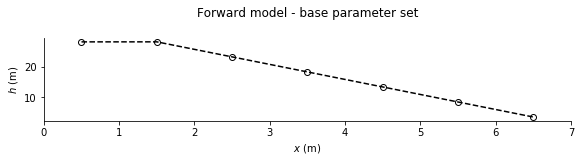

In [4]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Forward model - base parameter set\n')
s.set_aspect(0.04)
s.plot(X, hds_base, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$h$ (m)')
s.set_xlim(BC2x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False) 

Second, a perturbed forward model featuring an infinitesimal increase in $Q_w$ is run. 

In [5]:
ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(  ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head = BC1h)
BC2 = timml.LineDoubletImp(ml, x1=BC2x, y1=-100., x2=BC2x, y2=100., order= 1)
BC2 = timml.LineSink(      ml, x1=xw,   y1=-100., x2=xw,   y2=100., sigma=-Qw*(1.+dpar))
ml.solve()

hds_pert = np.array([ml.head(0, x, 0.) for x in X])
hob_pert = ml.head(0, obsx, 0.)

Starting solve
Number of elements:  3
Percent progress:  0  
size of matrix (3L, 3L)
Solution complete


The spatial distribution of hydraulic head calculated by the perturbed forward model can be presented visually as follows.

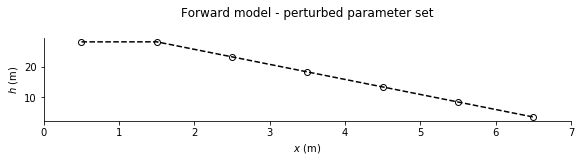

In [6]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Forward model - perturbed parameter set\n')
s.set_aspect(0.04)
s.plot(X, hds_pert, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$h$ (m)')
s.set_xlim(BC2x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False)            

Third, the perturbation-based sensitivity is calculated.

In [7]:
dh_dQw_pert = (hob_pert-hob_base)/(Qw*dpar)

### 3. Sensitivity calculation using adjoint state-based approach

First, the adjoint state model is defined. This is mostly identical to the forward model, except for three conditions: 
1. The value specified on the Dirichlet boundary is set to zero.
2. The flux specified on the Neumann boundary is set to zero; for this reason, a no-flow boundary condition is applied instead.
3. A constant source of adjoint state is specified at the location of the hydraulic head observation of interest using a  source term with flux magnitude equal to unity.

In [8]:
ml  = timml.Model(k=[K], zb=[-101.], zt=[-100.], c=[1.])
BC1 = timml.HeadLineSink(  ml, x1=BC1x, y1=-100., x2=BC1x, y2=100., head = 0.0)
BC2 = timml.LineDoubletImp(ml, x1=BC2x, y1=-100., x2=BC2x, y2=100., order= 1)
lt  = timml.LineSink(      ml, x1=obsx, y1=-100., x2=obsx, y2=100., sigma=-1.0)
ml.solve()

adj = np.array([ml.head(0, x, 0.) for x in X])

Starting solve
Number of elements:  3
Percent progress:  0  
size of matrix (3L, 3L)
Solution complete


The adjoint state model grid and boundary conditions can be presented visually as follows.

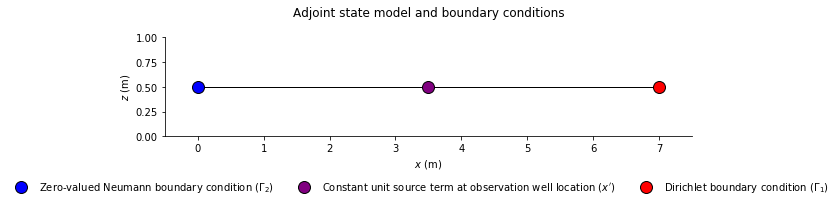

In [9]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_aspect(1.5)
s.set_title('Adjoint state model and boundary conditions\n')
s.set_xlim(BC2x-0.5, BC1x+0.5)
s.set_ylim(0., 1.)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.plot([BC2x, BC1x], [0.5, 0.5], 'k-', lw=1.)
s.plot(BC2x, 0.5, 'o', ms=12, mfc='b', mec='k', label='Zero-valued Neumann boundary condition ($\Gamma_2$)') 
s.plot(obsx, 0.5, 'o', ms=12, mfc='purple', mec='k', 
       label="Constant unit source term at observation well location ($x'$)") 
s.plot(BC1x, 0.5, 'o', ms=12, mfc='r', mec='k', label='Dirichlet boundary condition ($\Gamma_1$)') 
s.spines['right'].set_visible(False)
s.spines['top'].set_visible(False)
l = f.legend(fancybox=False, frameon=False, loc=8, ncol=3)

The spatial distribution of the adjoint state variable calculated by the adjoint model can be presented visually as follows.

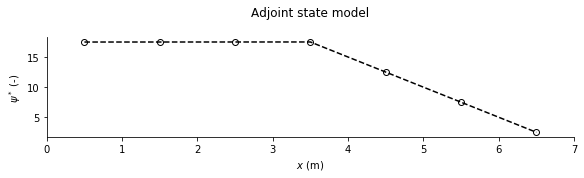

In [10]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 8.00/2.54])
s.set_title('Adjoint state model\n')
s.set_aspect(0.08)
s.plot(X, adj, 'ko--', mfc='none')
s.set_xlabel('$x$ (m)')
s.set_ylabel('$\psi^*$ (-)')
s.set_xlim(BC2x, BC1x)
s.spines['top'].set_visible(False)            
s.spines['right'].set_visible(False)            

Second, the adjoint state sensitivity is calculated. For this example [i.e. for the sensitivity $\partial h(x')/\partial Q_w$], this is calculated using a combination of forward and adjoint model outputs, as described by the equation presented above.

In [11]:
dh_dQw_adj = ml.head(0, Qw, 0.)

This comparison of divergence term values shows that the contribution of cells located upgradient of the observation location to the adjoint sensitivity will be zero.

### 4. Comparison of calculated sensitivities

In [12]:
print 'Perturbation-based sensitivity  = '+str('%14.6f'%  dh_dQw_pert)
print 'Adjoint state-based sensitivity = '+str('%14.6f'%  dh_dQw_adj)
print
print 'Ratio                           = '+str('%14.6e'% (dh_dQw_pert/dh_dQw_adj))
print 'Difference (absolute)           = '+str('%14.6e'% (dh_dQw_adj-dh_dQw_pert))
print 'Difference (percent)            = '+str('%14.6e'%  abs((dh_dQw_adj-dh_dQw_pert)/dh_dQw_pert))

Perturbation-based sensitivity  =      17.484236
Adjoint state-based sensitivity =      17.477899

Ratio                           =   1.000363e+00
Difference (absolute)           =  -6.336697e-03
Difference (percent)            =   3.624234e-04
